# FNO for Darcy flow 

Use Fourier Neural Operator (FNO) to solve Darcy flow problem.
We learn a mapping (operator) between a permeability field to the solution pressure field:

$$
-\nabla \cdot \left( k(x) \nabla u(x) \right) = f(x), x\in D,
$$

where $D$ is the domain, $k(x)$ is the permeability field, $u(x)$ is the pressure field, and $f(x)$ is the source term, the operator we want to learn: $\mathcal{L}: k(x) \mapsto u(x)$.

Domain $D$ is a 2D square domain $[0, 1]^2$, and both fields ($k(x), u(x)$) are discretized into 2D matrix $\mathbf{K}, \mathbf{u} \in \mathbb{R}^{N\times N}$

In [1]:
# packages
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

In [24]:
# load dataset
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=16,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[16, 16],
        encode_input=True, encode_output=False
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


x.shape: torch.Size([1, 16, 16])
y.shape: torch.Size([1, 16, 16])


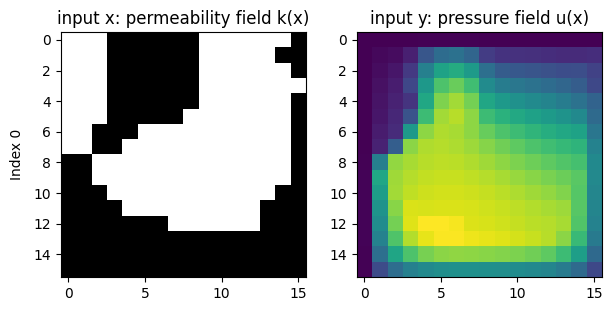

In [25]:
# check dataset
index = 0
data = train_loader.dataset[index]
x = data['x']
y = data['y']
print(f'x.shape: {x.shape}') # binary value (0 or 1), x grid, y grid
print(f'y.shape: {y.shape}') # solution value, x grid, y grid

# plot input x and input y
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.annotate(f"Index {index}", xy=(-0.15, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x: permeability field k(x)')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(y.squeeze())
ax.set_title('input y: pressure field u(x)')
plt.show()

In [55]:
# model setup
model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             n_layers=4,
             fno_skip='linear',
             positional_embedding='grid',
             projection_channel_ratio=2,
             factorization='Tucker')
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1211881 parameters.


In [57]:
# model setup
optimizer = AdamW(model.parameters(),
                                lr=5e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.5)

# loss functions
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}


print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): TuckerTensor(shape=(32, 32, 16, 9), rank=(32, 32, 16, 9))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

In [58]:
# %%capture out

# train
trainer = Trainer(model=model, n_epochs=50,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=1,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses,
              save_every=10,
              save_dir="./ckpt/")

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([16, 1, 16, 16])
[0] time=3.23, avg_loss=0.4868, train_err=7.7276
Eval: 16_h1=0.4076, 16_l2=0.2906, 32_h1=0.5020, 32_l2=0.3057
[Rank 0]: saved training state to ./ckpt/
[1] time=3.29, avg_loss=0.2698, train_err=4.2819
Eval: 16_h1=0.2356, 16_l2=0.1575, 32_h1=0.3743, 32_l2=0.1722
[2] time=3.13, avg_loss=0.2224, train_err=3.5304
Eval: 16_h1=0.2075, 16_l2=0.1366, 32_h1=0.3562, 32_l2=0.1525
[3] time=3.17, avg_loss=0.1993, train_err=3.1632
Eval: 16_h1=0.1877, 16_l2=0.1212, 32_h1=0.3556, 32_l2=0.1447
[4] time=3.31, avg_loss=0.1860, train_err=2.9518
Eval: 16_h1=0.1910, 16_l2=0.1202, 32_h1=0.3666, 32_l2=0.1459
[5] time=3.09, avg_loss=0.2023, train_err=3.2110
Eval: 16_h1=0.2359, 16_l2=0.2054, 32_h1=0.3732, 32_l2=0.2212
[6] time=3.28, avg_loss=0.1887, train_err=2.9952
Eval: 16_h1=0.2184, 16_l2=0.1804, 32_h1=0.3714, 32_l2=0.2006
[7] time=3.29, avg_loss=0.1783, train_err=2.8307
Eval

{'train_err': 0.8785283844622355,
 'avg_loss': 0.05534728822112083,
 'avg_lasso_loss': None,
 'epoch_train_time': 5.575350900006015,
 '16_h1': tensor(0.1690),
 '16_l2': tensor(0.0812),
 '32_h1': tensor(0.4339),
 '32_l2': tensor(0.1237)}

In [49]:
# print and save log

# out.show()
with open('log.txt', 'w') as f:
    f.write(out.stdout)

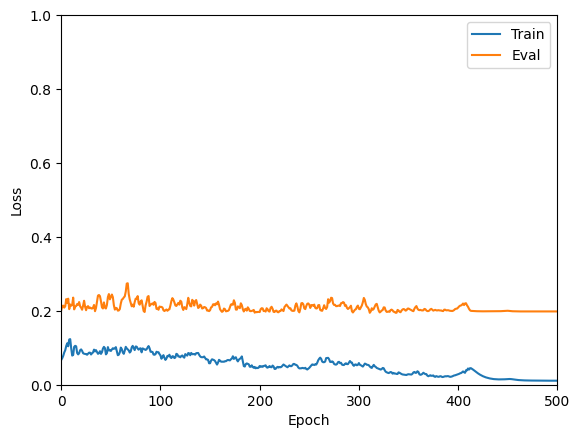

In [50]:
# plot train and eval loss
import re
import matplotlib.pyplot as plt

with open("log.txt", 'r') as f:
    log = f.read()

train_loss = [float(x) for x in re.findall(r"avg_loss=([0-9.]+)", log)]
eval_loss = [float(x) for x in re.findall(r"16_h1=([0-9.]+)", log)]

# train_loss_rel = [x / train_loss[0] for x in train_loss]
# eval_loss_rel = [x / eval_loss[0] for x in eval_loss]

# plot
fig, ax = plt.subplots()
ax.plot(train_loss, label='Train')
ax.plot(eval_loss, label='Eval')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set(xlim=[0, len(train_loss)], ylim=[0, 1])
ax.legend()
plt.show()

In [51]:
# save model
model.save_checkpoint("./model", save_name='fno')

In [52]:
# reload model
model_reload = FNO.from_checkpoint('./model', save_name="fno")

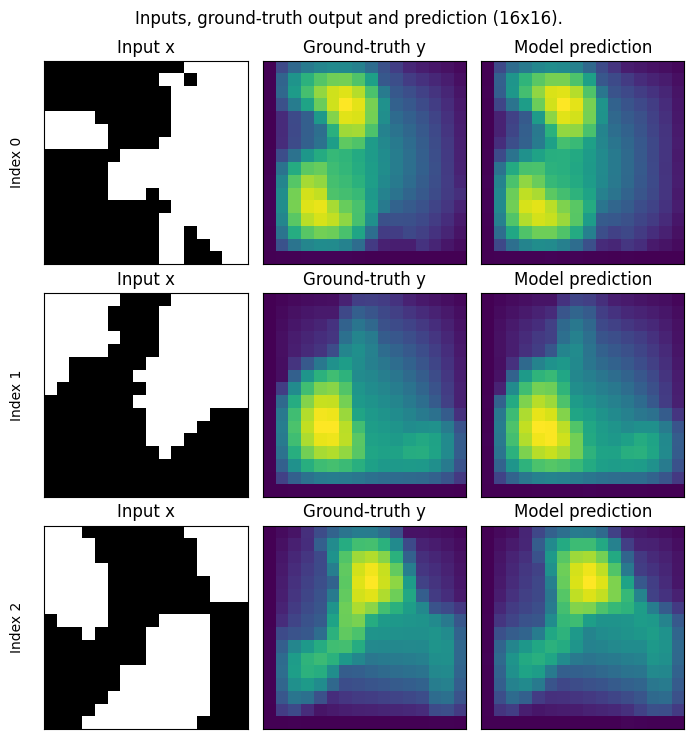

In [53]:
model_use = model
# model_use = model_reload

test_samples = test_loaders[16].dataset

tests = [0, 1, 2]

fig = plt.figure(figsize=(7, 2.5*len(tests)))
for id, test_id in enumerate(tests):
    data = test_samples[test_id]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model_use(x)

    ax = fig.add_subplot(len(tests), 3, id*3 + 1)
    ax.annotate(f"Index {test_id}", xy=(-0.1, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
    ax.imshow(x[0][0], cmap='gray', origin='lower')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(len(tests), 3, id*3 + 2)
    ax.imshow(y.squeeze(), origin='lower')
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(len(tests), 3, id*3 + 3)
    ax.imshow(out.squeeze().detach().numpy(), origin='lower')
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
plt.show()

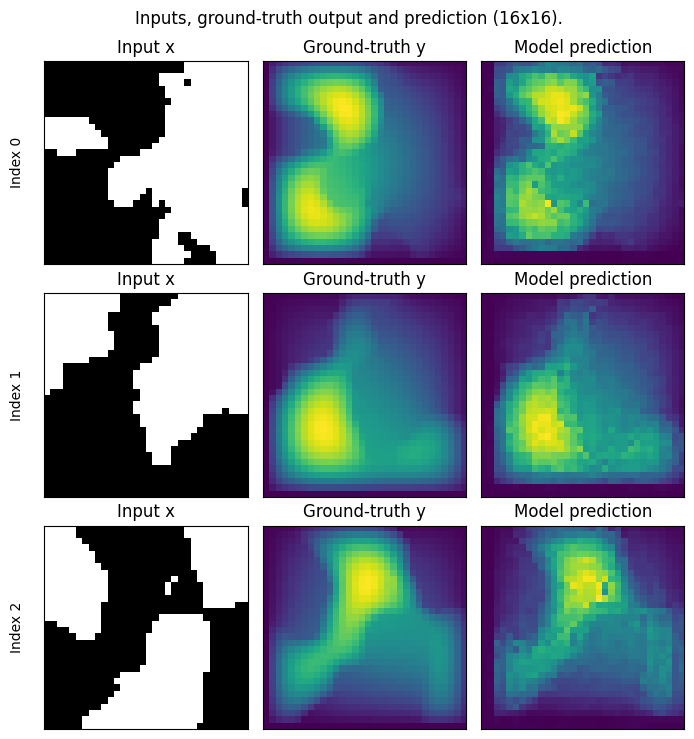

In [54]:
# model_use = model
model_use = model_reload

test_samples = test_loaders[32].dataset

tests = [0, 1, 2]

fig = plt.figure(figsize=(7, 2.5*len(tests)))
for id, test_id in enumerate(tests):
    data = test_samples[test_id]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model_use(x)

    ax = fig.add_subplot(len(tests), 3, id*3 + 1)
    ax.annotate(f"Index {test_id}", xy=(-0.1, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
    ax.imshow(x[0][0], cmap='gray', origin='lower')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(len(tests), 3, id*3 + 2)
    ax.imshow(y.squeeze(), origin='lower')
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(len(tests), 3, id*3 + 3)
    ax.imshow(out.squeeze().detach().numpy(), origin='lower')
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
plt.show()